In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

Text(0, 0.5, 'production/import [Mt]')

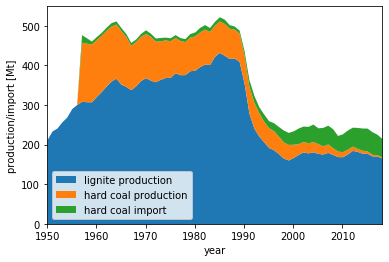

In [2]:
# import coal data
data_dir = 'data/'
bk = pd.read_csv(data_dir + 'Braunkohlefoerderung.csv', header=1, index_col=0)
sk = pd.read_csv(data_dir + 'Steinkohlefoerderung.csv', header=1, index_col=0)
si = pd.read_csv(data_dir + 'hard coal imports.csv', header=1, index_col=0)

coal_production = pd.merge(bk, sk, left_index=True, right_index=True, how='outer')
# convert from 1000 t to Mt
coal_production = coal_production / 1000
coal_production = pd.merge(coal_production, si, left_index=True, right_index=True, how='outer')

coal_production.interpolate().plot.area(linewidth=0)
#coal_production.interpolate().plot(linewidth=2)
plt.ylabel('production/import [Mt]')

In [3]:
# import classification
run_id = 2350

topic_dir = "plots/topic_analysis_{}/".format(run_id)
topic_classification = pd.read_csv(topic_dir + '0_topic_list_run{}_labeled.csv'.format(run_id), index_col=0)
topic_classification #['classification']

,label,label short,classification,label Finn,Discussion with Jan,Jan,Jan.1,Jan period,top words weighted,top words avg,top words peak,score pct,score
184089,common terms,common terms,procedural and general politics,stopwords,NaN,stop words,NaN,NaN,"tun, wirklich, wiss, red, gar, darub, natur, r...","tun, wiss, wirklich, red, gar, darub, natur, r...","ding, vielleicht, wirklich, gar, wiss, seh, we...",10.672064,419821.116446
184090,procedural,procedural,procedural and general politics,procedural,NaN,procedural,NaN,NaN,"darauf, haus, darub, darf, bereich, punkt, bun...","darauf, darub, haus, bereich, punkt, debatt, b...","haus, darauf, darf, darub, entscheid, lass, bu...",9.348242,367744.157874
184081,economic policy,economic policy,economy and budget,economic policy,NaN,Wirtschaftspolitik/ -entwicklung,NaN,NaN,"wirtschaft, unternehm, entwickl, deutsch, mark...","unternehm, wirtschaft, deutsch, deutschland, m...","wirtschaft, entwickl, bereich, wirtschaftspoli...",5.492435,216063.202495
184105,federal government,federal government,procedural and general politics,procedural 2,NaN,Bundesregierung,Procedere,NaN,"bundeskanzl, partei, regier, deutsch, sozialde...","bundeskanzl, deutsch, partei, deutschland, reg...","regier, bundeskanzl, volk, partei, sozialdemok...",4.037749,158838.262969
184102,policy statements,policy statements,procedural and general politics,economic system ?,NaN,NaN,Grundsatzreden,NaN,"deutsch, volk, bundesregier, freiheit, wirtsch...","deutsch, volk, bundesregier, freiheit, deutsch...","deutsch, deutschland, gemeinsam, wirtschaft, f...",3.989937,156957.446933
184106,budget,budget,economy and budget,budget,NaN,Haushaltspolitik/ Bundeshaushalt,NaN,1 bis 5/6 - hält sich aber,"milliard, million, bund, haushalt, hoh, rund, ...","milliard, bund, million, hoh, rund, haushalt, ...","million, milliard, bund, haushalt, hoh, bundes...",3.783282,148827.974002
184086,European Coal & Steel Community,ECSC,international and regional,German-French economic policy,NaN,Europäische (Wirtschafts-)gemeinschaft,Deutsch-französische Wirtschaftszusammenarbeit,NaN,"europa, deutsch, vertrag, franzos, frankreich,...","europa, union, gemeinschaft, deutsch, vertrag,...","deutsch, schumanplan, deutschland, vertrag, fr...",3.685528,144982.504003
184098,international cooperation,international cooperation,international and regional,Europe,international,Internationale Politik,Europäische Politk,NaN,"europa, gemeinsam, international, deutschland,...","europa, gemeinsam, international, staat, gemei...","deutschland, wichtig, international, gemeinsam...",3.627137,142685.511866
184108,energy supply mix,energy supply mix,energy,energy policy,NaN,Energiepolitik,look at topic score development and explain,NaN,"energi, erneuerbar, energiepolit, kohl, bundes...","energi, erneuerbar, kohl, energiepolit, energi...","energiepolit, bundesregier, energi, kohl, kern...",3.422472,134634.299691
184097,procedural 2,procedural 2,procedural and general politics,Mixed ?,Gesetzgebung?,Gesetzgebung,EWG highlighted,NaN,"gesetz, wirtschaft, bundesregier, entwurf, bun...","gesetz, wirtschaft, bundesregier, entwurf, bun...","ewg, rechtzeit, gesetz, endgult, wirtschaft, b...",3.160606,124332.949316


# show in plot:

- aggregated topic scores 
- number of speeches
- coal production
- governments (with color)
- policy events

In [4]:
run_id = 2350

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
dts.values('topic__title','ut__document__parlperiod__n').annotate(n = Sum('score'))
topic_period_scores = dts.values('topic__title','topic__id', 'ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df["classification"] = df["topic__id"]
def id_to_class(idn):
    return topic_classification.loc[idn]['classification']
df["classification"] = df["classification"].apply(id_to_class)

dfagg = df.groupby(["classification","ut__document__parlperiod__n"]).sum().drop(columns=["topic__id"])

dfagg = dfagg.unstack().transpose().droplevel(0)

{'n': 3933832.450001959}


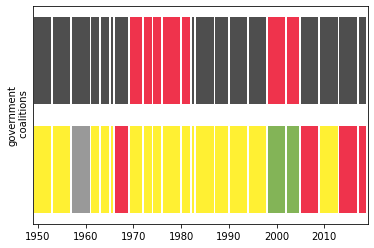

In [5]:
party_color_map = {'spd': "#0088FF", 'cducsu': "#222222", 'fdp': "#FFED00",
                   'gruene': "#64A12D", 'linke': "#8C3473", 'spd': "#EB001F", 'dp': '#808080'}

gvmt = pd.read_csv(data_dir + 'List of German governments.csv', header=1)

def plot_government(ax, triangle=False, ylabel_pad=None, x_pad=0.2, y_pad=0.05):
    from matplotlib.patches import Rectangle, Polygon

    for i in gvmt.index:
        if triangle:
            xy = np.array([[gvmt.loc[i]['begin year'], 1],
                      [gvmt.loc[i]['end year'], 1],
                      [gvmt.loc[i]['begin year'], 0]])
            rect = Polygon(xy, alpha=0.8,
                             edgecolor='k', linewidth=0, facecolor = party_color_map[gvmt.loc[i]['Party 1']]) 
            ax.add_patch(rect)
            xy = np.array([[gvmt.loc[i]['begin year'], 0],
                      [gvmt.loc[i]['end year'], 1],
                      [gvmt.loc[i]['end year'], 0]])
            rect = Polygon(xy, alpha=0.8,
                             edgecolor='k', linewidth=0, facecolor = party_color_map[gvmt.loc[i]['Party 2']]) 
            ax.add_patch(rect)

        else:
            width = gvmt.loc[i]['end year'] - gvmt.loc[i]['begin year'] - 2*x_pad
            height = 0.5 - 2 * y_pad
            pos = gvmt.loc[i]['begin year'] + x_pad
            rect = Rectangle((pos, 0.5 + y_pad), width, height, alpha=0.8,
                             edgecolor='k', linewidth=0, facecolor = party_color_map[gvmt.loc[i]['Party 1']]) 
            ax.add_patch(rect)
            rect = Rectangle((pos, y_pad), width, height, alpha=0.8,
                             edgecolor='k', linewidth=0, facecolor = party_color_map[gvmt.loc[i]['Party 2']]) 
            ax.add_patch(rect)
    
    ax.set_xlim([1948.9, 2019.1])
    ax.set_yticks([])
    ax.grid(False)
    ax.set_ylabel('government\n coalitions', labelpad=ylabel_pad)
    
ax = plt.subplot(111)
plot_government(ax)

In [6]:
mid_years = np.array([1951. , 1955. , 1959. , 1963. , 1967, 1970.5,
                      1974  , 1978. , 1981.5 , 1985. , 1988.5, 1992. ,
                      1996. , 2000. , 2003.5, 2007. , 2011. , 2015. , 2018. ])

In [7]:
# load event table:
filename = "Policy events coal.csv"
polevents = pd.read_csv(filename, header=1).fillna("")
polevents

,year,period,policy event,short label,"explanation, legislation",type of event,scope
0,1951,1,Creation of the European Coal and Steel Community,Creation of the ECSC,,international treaty,international
1,1957,3,European Economic Community,European Economic Community,,international treaty,international
2,1965,5,Law to ensure German hard coal use in power ge...,1. Verstromungsgesetz,1. Verstromungsgesetz,legislation,national
3,1971,6,First environmental program,First environmental program,Umweltprogramm,government policy,national
4,1974,7,Introduction of “Kohlepfennig”,Kohlepfennig,extra charge on electricity for coal mined Ger...,legislation,national
5,1974,7,Pollution control law,Pollution control law,Bundes-Immissionsschutzgesetz,legislation,national
6,1980,9,Jahrhundertvertrag,Jahrhundertvertrag,treaty between electricity utilities and minin...,government policy,national
7,1983,10,Entry of green party in parliament,Green party enters parliament,,parliamentary event,national
8,1986,10,Chernobyl nuclear disaster,Chernobyl nuclear disaster,,international event,international
9,1986,10,Creation of the federal environmental ministry,Federal environmental ministry,,government policy,national


In [8]:
concat_polevents = polevents.groupby('year')['short label'].apply(', '.join)
concat_polevents[2000] = "Eco tax, EEG, Nuclear phase-out decision"
concat_polevents = concat_polevents.drop(1999)
concat_polevents

year
1951                                 Creation of the ECSC
1957                          European Economic Community
1965                                1. Verstromungsgesetz
1971                          First environmental program
1974                  Kohlepfennig, Pollution control law
1980                                   Jahrhundertvertrag
1983                        Green party enters parliament
1986    Chernobyl nuclear disaster, Federal environmen...
1990                                 German reunification
1992                                       Rio Conference
1994                                               UNFCCC
1997           Hard coal mining subsidies, Kyoto protocol
2000             Eco tax, EEG, Nuclear phase-out decision
2005                                               EU ETS
2007                               Coal subsidy phase-out
2011                           Fukushima, Atom-Moratorium
2015                                      Paris agreement
2016     

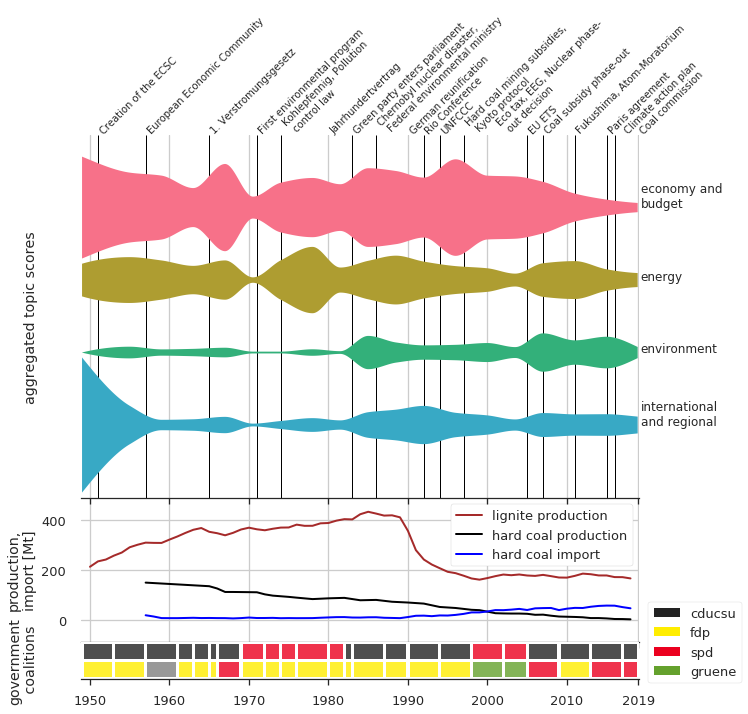

In [19]:
interpolate = True

if interpolate:
    from scipy.interpolate import PchipInterpolator
    x_years = np.arange(1949, 2019, 0.1)
    
from matplotlib.patches import ConnectionPatch
import matplotlib.lines
import textwrap

sns.set_context("talk")
sns.set_style("ticks")
sns.set_style({'axes.spines.bottom': True,
               'axes.grid':True,
               'axes.spines.left': False,
               'axes.spines.right': False,
               'axes.spines.top': False,
               'ytick.left': False,
               'figure.facecolor':'w'})

sns.set_palette('husl', 5)
colors = sns.color_palette()
sns.set_palette(list(reversed(colors[:4])))

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 10),
                       gridspec_kw={'height_ratios': [5, 2, 0.5]})

# set up values for figure scaling
dfs = dfagg[["economy and budget", "energy", "environment",
             "international and regional"]]
max_val = 1.5 * dfs.max().max()
y_max = len(dfs.columns)*max_val

# draw events
# =================================================================
# draw lines across multiple subplots:
# https://stackoverflow.com/questions/17543359/drawing-lines-between-two-plots-in-matplotlib
#lines = []

#for year in np.arange(1950,2020, 10):
        
    #option 1:
    #con = ConnectionPatch(xyA=[year, y_max], xyB=[year, 0], coordsA="data", coordsB="data",
    #                      axesA=ax[0], axesB=ax[2], color='gray', zorder=200)
    #ax[0].add_artist(con)

    #option 2:
    #transFigure = fig.transFigure.inverted()

    #coord1 = transFigure.transform(ax[0].transData.transform([year, y_max]))
    #coord2 = transFigure.transform(ax[2].transData.transform([year, 0]))

    #lines.append(matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
    #                           transform=fig.transFigure, color='k', linewidth=1))

#fig.lines = lines
# =================================================================

# plot coal production
coal_production.interpolate().plot(linewidth=2, ax=ax[1], color=['brown', 'k', 'b'])
ax[1].set_ylabel('production,\nimport [Mt]')
ax[1].set_ylim([-90,490])
ax[1].legend(frameon=True, framealpha=1)

gov_parties = ['cducsu', 'fdp', 'spd', 'gruene']
legend_elements = [Patch(facecolor=party_color_map[party], label=party) for party in gov_parties]#edgecolor='r',
ax[2].legend(handles=legend_elements, loc='center', bbox_to_anchor=(1.1, 1.0), frameon=True)

# plot government coalitions
plot_government(ax[2], ylabel_pad=43)

# plot policy events
for index in concat_polevents.index:
    year = index
    text = "\n ".join(textwrap.wrap(concat_polevents[year], 30))

    ax[0].vlines(year, ymin=-max_val, ymax=y_max, linewidth=1, zorder=0)
    if concat_polevents[year] in ["Climate action plan", "Eco tax, EEG, Nuclear phase-out decision"]:
        year = year + 1

    ax[0].text(year, y_max, text, ha="left", va="bottom", rotation=45, size=10)
    

# plot aggregate topics
#ax[0].set_yticks(np.arange(0, y_max, max_val))
ax[0].set_yticks([])

for i, t in enumerate(reversed(dfs.columns)):
    if interpolate:
        interp_func = PchipInterpolator(mid_years, dfs[t])

        ax[0].fill_between(x_years, interp_func(x_years) + i*max_val, i*max_val - interp_func(x_years), label=t)
    else:
        ax[0].fill_between(mid_years, dfs[t] + i*max_val, i*max_val - dfs[t], label=t)
    ax[0].text(2019.3, (i+0.) *max_val, textwrap.fill(t, 16), fontsize=12)

ax[0].set_xlabel('year')
ax[0].set_ylabel('aggregated topic scores', labelpad=43)
ax[0].set_ylim([-max_val, y_max])
ax[0].set_xticks([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2019])

#ax[1].patch.set_facecolor('none')
ax[0].set_zorder(2)
plt.subplots_adjust(hspace=.0)

plt.savefig(os.path.join(save_dir, 'topic_evolution_run{}_aggregate.png'.format(run_id)),
            dpi=150, bbox_inches="tight", facecolor=fig.get_facecolor())